In [19]:
# import talib as ta

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
import seaborn as sns
import matplotlib.pyplot as plt
import csv
#from factor_analyzer import FactorAnalyzer
import warnings
warnings.filterwarnings(action='ignore')
from sklearn.linear_model import LogisticRegression
from sklearn.tree import export_graphviz, DecisionTreeClassifier
import pygraphviz as pgv
from IPython.display import Image
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" # 한 실행칸에 프린트 여러개 해도 다 출력시키도록 하는 코드.
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


## Data 전처리

In [2]:
raw_data = pd.read_csv('./data.csv')
tech = pd.read_csv('./tech.csv')

raw_data['datetime'] = raw_data['일자'] + ' ' + raw_data['시간']
raw_data['datetime'] = pd.to_datetime(raw_data['datetime'], format='%Y/%m/%d')

# 2020-06-30일 까지로 Data Cut
raw_data = raw_data.iloc[:65284]
tech = tech.iloc[:65284]

data = raw_data[['datetime', '종가']]
data.columns = ['datetime', 'close']
data = pd.concat([data, tech], axis = 1)
data = data.dropna(axis=0).iloc[:,1:]

In [3]:
#PCA data / Softmax data 분리
pca_selection_data_set = data[:-(396*40)]
classify_predict_data_set = data[-(396*40):]

train_test_index = classify_predict_data_set.index[0]

## 분류 Y_Label

In [4]:
# y date list
date_list = [1, 3, 5, 10, 15, 20]

In [5]:
def classify_y_label(data, date_list):
    
    data['std_120m'] = data['close'].rolling(120).std() #for Boundary

    data.dropna(inplace = True)
#     data.reset_index(inplace = True, drop = True)

    # making y
    for i in date_list:
        close_after = data['close'].shift(-i)
#         nans = np.empty(i)
#         nans = np.nan
#         close_after = close_after.append(pd.Series(nans, index = np.arange(len(close_after), len(close_after) + i)))
        label =  'y_' + str(i) +'m'

        lower_bound = data['close'] - data['std_120m'] / np.sqrt(120//i)
        upper_bound = data['close'] + data['std_120m'] / np.sqrt(120//i)

        up = close_after >= upper_bound
        down = close_after < lower_bound
        y = 1 * up -1 * down

        data[label] = y

    data.drop(['std_120m'], axis = 1, inplace = True)
    
    data = data[['y_1m','y_3m','y_5m','y_10m','y_15m','y_20m']]
    
    return data

In [6]:
y_data = classify_y_label(data.copy(), date_list)

In [7]:
y_data

,y_1m,y_3m,y_5m,y_10m,y_15m,y_20m
207,-1,0,0,0,0,0
208,0,0,0,0,0,0
209,0,0,0,0,0,0
210,0,0,0,0,0,0
211,0,0,0,0,0,0
...,...,...,...,...,...,...
65279,-1,0,0,0,0,0
65280,1,1,0,0,0,0
65281,0,0,0,0,0,0
65282,1,0,0,0,0,0


## 연속형 Y_Label

In [8]:

"""
    해야 되는 것.
    1. (1~20)분 후의 가격 ~ price_1m
    2. (1~20)분 후의 로그수익률 ~ lgret_1m
    3. (1~20)분 후의 절대수익률 ~ ret_1m
"""
data2 = pca_selection_data_set.copy()
original_col = data2.columns.to_list()

for i in range(1, 21):
    num_label = str(i) + 'm'
    data2['price_' + num_label] = (data2['close'].shift(-i) - data2['close']) * 100
    data2['ret_' + num_label] = ((data2['close'].shift(-i) - data2['close'])/data2['close']) * 100
    data2['logret_' + num_label] = (np.log(data2['close'].shift(-i)/data2['close'])) * 100

'\n    해야 되는 것.\n    1. (1~20)분 후의 가격 ~ price_1m\n    2. (1~20)분 후의 로그수익률 ~ lgret_1m\n    3. (1~20)분 후의 절대수익률 ~ ret_1m\n'

In [9]:
def extract_data(method, period, data): # method : ('price', 'ret', 'logret'), period = 1~20
    label = method + '_' + str(period) + 'm'
    cols = original_col.copy()
    cols.append(label)
    _data = data[cols]
    # _data.set_index('datetime', inplace = True, drop = True)
    _data.dropna(inplace = True)
    return _data

## LASSO variable selection

In [10]:
def lasso_result(x, parameter):
    all_dict = {}

    X_train = x.iloc[:,:-1]
    y_train = x.iloc[:,[-1]]

    fig, axs = plt.subplots(figsize=(200,200), nrows=1, ncols=len(parameter) )
    coeff_df = pd.DataFrame()

     # sns.set(font="AppleGothic", 
     #        rc={"axes.unicode_minus":False},
      #       style='darkgrid',font_scale=15)    

    for pos, al in enumerate(parameter):
        lasso = Lasso(alpha=al)
        lasso.fit ( X_train, y_train)
        print(lasso)
        coeff = pd.DataFrame(data=lasso.coef_, index=list(X_train.columns),columns=['coeff_value'])
        coeff['abs_coeff_value'] = abs(coeff['coeff_value'])
        coeff = coeff.sort_values('abs_coeff_value',ascending=False)
        colname = 'alpha:'+str(al)
      #  axs[pos].set_title(colname)
       # axs[pos].set_xlim(-4,4)  
        
        coeff_notzero= coeff['coeff_value'][coeff['abs_coeff_value']>=0.01]
      #  if len(coeff_notzero)>0:
           # sns.barplot( x=coeff_notzero.values, y=coeff_notzero.index, ax=axs[pos])
        all_dict[colname] = coeff
    return(all_dict)

In [11]:
def lasso_feature_selection(rank,data,alphas):  
    list_all = pd.Series()
    alpha_all = pd.Series()
    
    for i in ['price', 'ret', 'logret'] :
        for j in [1,3,5,7,9,11,13,15,17,19]:
            result_lasso= lasso_result(extract_data(i,j,data).iloc[:-1],alphas)
            for k in range(len(list(result_lasso.keys()))):        
                result_frame_temp = result_lasso[list(result_lasso.keys())[k]] 
                list_temp=pd.Series(result_frame_temp[result_frame_temp['abs_coeff_value']>0.01].iloc[:rank].index)
                list_all=list_all.append(list_temp)
                alpha_all = alpha_all.append(pd.Series(list(result_lasso.keys())[k]).repeat(len(list_temp)))
#                 print(i)
#                 print(j)
#                 print(list_all.value_counts())
                
#                 print(result_frame_temp[result_frame_temp['abs_coeff_value']>0.01].iloc[:rank])
    alpha_all.reset_index(inplace=True, drop=True)
    list_all.reset_index(inplace=True, drop=True)
    
    final_frame = pd.DataFrame({'feature_all':list_all,'alpha':alpha_all})
    return(final_frame)

In [13]:
# alpha = [0.0001, 0.001, 0.01,0.1]
# result_varaible = lasso_feature_selection(10, data2,alpha)

In [14]:
#결과값 CSV 저장
#pd.Series(selected_variable).to_csv('./lasso_selection_variable.csv')

## PCA Analysis & Prediction

In [12]:
selected_variable = pd.read_csv('./lasso_selection_variable.csv')
selected_variable = selected_variable['0']

In [13]:
def run_pca_analysis(_train_set, _test_set, _LASSO_columns, threshold, draw_plot):
    
    train_pca_res = train_set_pca_factor(_train_set, threshold, _LASSO_columns, draw_plot)
    
    train_pca_factors = train_pca_res[0]
    train_loadings = train_pca_res[1]
    
    LASSOed_test_set = _test_set[_LASSO_columns]
    test_pca_factors = LASSOed_test_set @ train_loadings
    
    
    
    return train_pca_factors, train_loadings, test_pca_factors

In [14]:
# X = LASSO로 의미없는 변수 제거한 DataFrame

def train_set_pca_factor(_train_set, threshold, _LASSO_columns, draw_plot = False):
    
    LASSOed_train_set = _train_set[_LASSO_columns]
    max_pca_factor = LASSOed_train_set.shape[1]
    LASSOed_train_set = StandardScaler().fit_transform(LASSOed_train_set)
    pca = PCA(n_components = max_pca_factor)
    principalComponents = pca.fit_transform(LASSOed_train_set)
    explain_var = pca.explained_variance_ratio_
    num_pca_factor = len(explain_var[explain_var.cumsum() < threshold])
    print("PCA threshold 넘기기 위해 필요한 최소 Factor: ",num_pca_factor)
    
    if draw_plot == True:
        fig, axes = plt.subplots(nrows=2, ncols=1)

        axes[0].plot(explain_var.cumsum(), label = "explained_Var")
        axes[1].set_xlabel("# of PCA Factors")
        axes[0].set_ylabel("cum_explained_variance")
        axes[0].set_title("PCA_explained_variance")
        axes[0].axhline(y=0.7, color='r', linewidth=1, label = "dd")
        axes[0].legend(["explained_Var", "Threshold"])


        axes[1].bar(np.arange(max_pca_factor) , explain_var)
        axes[1].set_ylabel("explained_variance")
    
    pca = PCA(n_components = num_pca_factor)
    principalComponents = pca.fit_transform(LASSOed_train_set)
    train_set_pca_factors = pd.DataFrame(data=principalComponents, 
                                         columns=["PC"+str(i+1) for i in range(num_pca_factor)])
    
    _LASSO_columns = np.array(_LASSO_columns)
    train_set_loadings = pd.DataFrame(pca.components_.T,
                        columns=["PC"+str(i+1) for i in range(num_pca_factor)],
                        index=np.array(_LASSO_columns).T)
    
    return train_set_pca_factors, train_set_loadings, explain_var

# Logistic(Softmax) Regression

In [18]:
# PCA & Moving Window & Prediction(Softmax)

window_size = 396 # 1 day data
train_size = window_size * 5
test_size = window_size

result_dict = {}

for j in range(len(date_list)):
    y_label = "y_" + str(date_list[j]) + "m"
    y = y_data.loc[train_test_index:, y_label]
    i = train_test_index
    test_results = pd.DataFrame(columns=['act_'+str(date_list[j]),'pred_'+str(date_list[j])])
    while(i + train_size + test_size <= len(data)):
        print(y_label,raw_data['datetime'].loc[i + train_size + test_size] )
        print(raw_data['datetime'].loc[len(data)])
        
        # PCA func (with YK's func)
        _, _, sub_data = run_pca_analysis(pca_selection_data_set, 
                                          classify_predict_data_set.loc[i:i+train_size + test_size] ,
                                          selected_variable, 0.7, draw_plot = False )
        
        
 
           # 데이터 쪼개기 : train & test data
        train = pd.concat([sub_data.loc[i : i + train_size], y.loc[i : i + train_size]], axis=1)
        test = pd.concat([sub_data.loc[i+train_size : i+train_size + test_size], y.loc[i+train_size : i+train_size + test_size]], axis=1)
        
        # train : like logistic regression(with softmax)
        
        softmax_reg = LogisticRegression(multi_class="auto", random_state = None)
        softmax_reg.fit(train.iloc[:,:-1], train.iloc[:, -1])
        
        
        # test : 
        res = softmax_reg.predict(test.iloc[:,:-1])
        
        test_results = pd.concat([test_results, 
                                  pd.DataFrame({'act_'+str(date_list[j]):test.iloc[:, -1],
                                                'pred_'+str(date_list[j]):res})])
        
        i = i + window_size
        
    result_dict[y_label] = test_results # {'y_1m' : [], 'y_3m' : []} []은 y & yhat

y_1m 2020-05-13 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_1m 2020-05-14 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_1m 2020-05-15 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_1m 2020-05-18 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_1m 2020-05-19 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_1m 2020-05-20 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_1m 2020-05-21 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_1m 2020-05-22 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_1m 2020-05-25 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_1m 2020-05-26 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_1m 2020-05-27 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_1m 2020-05-28 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_1m 2020-05-29 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_1m 2020-06-01 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_1m 2020-06-02 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_1m 2020-06-03 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_1m 2020-06-04 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_1m 2020-06-05 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_1m 2020-06-08 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_1m 2020-06-09 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_1m 2020-06-10 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_1m 2020-06-12 09:00:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_1m 2020-06-15 09:00:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_1m 2020-06-16 09:00:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_1m 2020-06-17 09:00:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_1m 2020-06-18 09:00:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_1m 2020-06-19 09:00:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_1m 2020-06-22 09:00:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_1m 2020-06-23 09:00:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_1m 2020-06-24 09:00:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_1m 2020-06-25 09:00:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_1m 2020-06-26 09:00:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_1m 2020-06-29 09:00:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_1m 2020-06-30 09:00:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_3m 2020-05-13 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_3m 2020-05-14 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_3m 2020-05-15 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_3m 2020-05-18 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_3m 2020-05-19 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_3m 2020-05-20 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_3m 2020-05-21 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_3m 2020-05-22 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_3m 2020-05-25 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_3m 2020-05-26 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_3m 2020-05-27 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_3m 2020-05-28 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_3m 2020-05-29 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_3m 2020-06-01 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_3m 2020-06-02 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_3m 2020-06-03 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_3m 2020-06-04 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_3m 2020-06-05 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_3m 2020-06-08 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_3m 2020-06-09 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_3m 2020-06-10 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_3m 2020-06-12 09:00:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_3m 2020-06-15 09:00:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_3m 2020-06-16 09:00:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_3m 2020-06-17 09:00:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_3m 2020-06-18 09:00:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_3m 2020-06-19 09:00:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_3m 2020-06-22 09:00:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_3m 2020-06-23 09:00:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_3m 2020-06-24 09:00:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_3m 2020-06-25 09:00:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_3m 2020-06-26 09:00:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_3m 2020-06-29 09:00:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_3m 2020-06-30 09:00:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_5m 2020-05-13 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_5m 2020-05-14 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_5m 2020-05-15 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_5m 2020-05-18 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_5m 2020-05-19 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_5m 2020-05-20 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_5m 2020-05-21 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_5m 2020-05-22 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_5m 2020-05-25 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_5m 2020-05-26 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_5m 2020-05-27 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_5m 2020-05-28 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_5m 2020-05-29 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_5m 2020-06-01 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_5m 2020-06-02 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_5m 2020-06-03 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_5m 2020-06-04 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_5m 2020-06-05 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_5m 2020-06-08 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_5m 2020-06-09 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_5m 2020-06-10 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_5m 2020-06-12 09:00:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_5m 2020-06-15 09:00:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_5m 2020-06-16 09:00:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_5m 2020-06-17 09:00:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_5m 2020-06-18 09:00:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_5m 2020-06-19 09:00:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_5m 2020-06-22 09:00:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_5m 2020-06-23 09:00:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_5m 2020-06-24 09:00:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_5m 2020-06-25 09:00:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_5m 2020-06-26 09:00:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_5m 2020-06-29 09:00:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_5m 2020-06-30 09:00:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_10m 2020-05-13 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_10m 2020-05-14 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_10m 2020-05-15 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_10m 2020-05-18 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_10m 2020-05-19 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_10m 2020-05-20 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_10m 2020-05-21 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_10m 2020-05-22 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_10m 2020-05-25 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_10m 2020-05-26 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_10m 2020-05-27 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_10m 2020-05-28 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_10m 2020-05-29 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_10m 2020-06-01 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_10m 2020-06-02 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_10m 2020-06-03 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_10m 2020-06-04 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_10m 2020-06-05 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_10m 2020-06-08 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_10m 2020-06-09 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_10m 2020-06-10 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_10m 2020-06-12 09:00:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_10m 2020-06-15 09:00:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_10m 2020-06-16 09:00:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_10m 2020-06-17 09:00:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_10m 2020-06-18 09:00:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_10m 2020-06-19 09:00:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_10m 2020-06-22 09:00:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_10m 2020-06-23 09:00:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_10m 2020-06-24 09:00:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_10m 2020-06-25 09:00:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_10m 2020-06-26 09:00:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_10m 2020-06-29 09:00:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_10m 2020-06-30 09:00:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_15m 2020-05-13 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_15m 2020-05-14 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_15m 2020-05-15 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_15m 2020-05-18 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_15m 2020-05-19 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_15m 2020-05-20 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_15m 2020-05-21 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_15m 2020-05-22 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_15m 2020-05-25 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_15m 2020-05-26 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_15m 2020-05-27 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_15m 2020-05-28 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_15m 2020-05-29 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_15m 2020-06-01 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_15m 2020-06-02 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_15m 2020-06-03 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_15m 2020-06-04 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_15m 2020-06-05 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_15m 2020-06-08 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_15m 2020-06-09 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_15m 2020-06-10 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_15m 2020-06-12 09:00:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_15m 2020-06-15 09:00:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_15m 2020-06-16 09:00:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_15m 2020-06-17 09:00:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_15m 2020-06-18 09:00:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_15m 2020-06-19 09:00:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_15m 2020-06-22 09:00:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_15m 2020-06-23 09:00:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_15m 2020-06-24 09:00:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_15m 2020-06-25 09:00:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_15m 2020-06-26 09:00:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_15m 2020-06-29 09:00:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_15m 2020-06-30 09:00:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_20m 2020-05-13 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_20m 2020-05-14 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_20m 2020-05-15 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_20m 2020-05-18 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_20m 2020-05-19 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_20m 2020-05-20 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_20m 2020-05-21 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_20m 2020-05-22 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_20m 2020-05-25 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_20m 2020-05-26 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_20m 2020-05-27 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_20m 2020-05-28 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_20m 2020-05-29 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_20m 2020-06-01 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_20m 2020-06-02 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_20m 2020-06-03 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_20m 2020-06-04 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_20m 2020-06-05 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_20m 2020-06-08 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_20m 2020-06-09 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_20m 2020-06-10 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_20m 2020-06-12 09:00:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_20m 2020-06-15 09:00:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_20m 2020-06-16 09:00:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_20m 2020-06-17 09:00:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_20m 2020-06-18 09:00:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_20m 2020-06-19 09:00:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_20m 2020-06-22 09:00:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_20m 2020-06-23 09:00:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_20m 2020-06-24 09:00:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_20m 2020-06-25 09:00:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_20m 2020-06-26 09:00:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_20m 2020-06-29 09:00:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

y_20m 2020-06-30 09:00:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

# Decision Tree

In [100]:
# PCA & Moving Window & Prediction(Softmax)

window_size = 396 # 1 day data
train_size = window_size * 5
test_size = window_size

result_dict = {}

for j in range(len(date_list)):
    y_label = "y_" + str(date_list[j]) + "m"
    y = y_data.loc[train_test_index:, y_label]
    i = train_test_index
    test_results = pd.DataFrame(columns=['act_'+str(date_list[j]),'pred_'+str(date_list[j])])
    while(i + train_size + test_size <= len(data)):
        print(y_label,raw_data['datetime'].loc[i + train_size + test_size] )
        print(raw_data['datetime'].loc[len(data)])
        
        # PCA func (with YK's func)
        _, _, sub_data = run_pca_analysis(pca_selection_data_set, 
                                          classify_predict_data_set.loc[i:i+train_size + test_size] ,
                                          selected_variable, 0.7, draw_plot = False )
        
        
        # 데이터 쪼개기 : train & test data
        train = pd.concat([sub_data.loc[i : i + train_size], y.loc[i : i + train_size]], axis=1)
        test = pd.concat([sub_data.loc[i+train_size : i+train_size + test_size], y.loc[i+train_size : i+train_size + test_size]], axis=1)
        
        # train : like logistic regression(with softmax)
        decision_tree = DecisionTreeClassifier(random_state = 123, min_samples_split = 500)
        decision_tree.fit(train.iloc[:,:-1], train.iloc[:, -1])
        
        
        # test : 
        res = decision_tree.predict(test.iloc[:,:-1])
        
        test_results = pd.concat([test_results, 
                                  pd.DataFrame({'act_'+str(date_list[j]):test.iloc[:, -1],
                                                'pred_'+str(date_list[j]):res})])
        
        i = i + window_size
        
    result_dict[y_label] = test_results # {'y_1m' : [], 'y_3m' : []} []은 y & yhat

y_1m 2020-05-13 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_1m 2020-05-14 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_1m 2020-05-15 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_1m 2020-05-18 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_1m 2020-05-19 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_1m 2020-05-20 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_1m 2020-05-21 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_1m 2020-05-22 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_1m 2020-05-25 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_1m 2020-05-26 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_1m 2020-05-27 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_1m 2020-05-28 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_1m 2020-05-29 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_1m 2020-06-01 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_1m 2020-06-02 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_1m 2020-06-03 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_1m 2020-06-04 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_1m 2020-06-05 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_1m 2020-06-08 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_1m 2020-06-09 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_1m 2020-06-10 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_1m 2020-06-12 09:00:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_1m 2020-06-15 09:00:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_1m 2020-06-16 09:00:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_1m 2020-06-17 09:00:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_1m 2020-06-18 09:00:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_1m 2020-06-19 09:00:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_1m 2020-06-22 09:00:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_1m 2020-06-23 09:00:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_1m 2020-06-24 09:00:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_1m 2020-06-25 09:00:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_1m 2020-06-26 09:00:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_1m 2020-06-29 09:00:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_1m 2020-06-30 09:00:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_3m 2020-05-13 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_3m 2020-05-14 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_3m 2020-05-15 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_3m 2020-05-18 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_3m 2020-05-19 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_3m 2020-05-20 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_3m 2020-05-21 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_3m 2020-05-22 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_3m 2020-05-25 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_3m 2020-05-26 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_3m 2020-05-27 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_3m 2020-05-28 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_3m 2020-05-29 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_3m 2020-06-01 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_3m 2020-06-02 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_3m 2020-06-03 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_3m 2020-06-04 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_3m 2020-06-05 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_3m 2020-06-08 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_3m 2020-06-09 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_3m 2020-06-10 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_3m 2020-06-12 09:00:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_3m 2020-06-15 09:00:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_3m 2020-06-16 09:00:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_3m 2020-06-17 09:00:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_3m 2020-06-18 09:00:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_3m 2020-06-19 09:00:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_3m 2020-06-22 09:00:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_3m 2020-06-23 09:00:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_3m 2020-06-24 09:00:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_3m 2020-06-25 09:00:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_3m 2020-06-26 09:00:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_3m 2020-06-29 09:00:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_3m 2020-06-30 09:00:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_5m 2020-05-13 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_5m 2020-05-14 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_5m 2020-05-15 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_5m 2020-05-18 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_5m 2020-05-19 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_5m 2020-05-20 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_5m 2020-05-21 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_5m 2020-05-22 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_5m 2020-05-25 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_5m 2020-05-26 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_5m 2020-05-27 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_5m 2020-05-28 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_5m 2020-05-29 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_5m 2020-06-01 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_5m 2020-06-02 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_5m 2020-06-03 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_5m 2020-06-04 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_5m 2020-06-05 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_5m 2020-06-08 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_5m 2020-06-09 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_5m 2020-06-10 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_5m 2020-06-12 09:00:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_5m 2020-06-15 09:00:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_5m 2020-06-16 09:00:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_5m 2020-06-17 09:00:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_5m 2020-06-18 09:00:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_5m 2020-06-19 09:00:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_5m 2020-06-22 09:00:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_5m 2020-06-23 09:00:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_5m 2020-06-24 09:00:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_5m 2020-06-25 09:00:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_5m 2020-06-26 09:00:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_5m 2020-06-29 09:00:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_5m 2020-06-30 09:00:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_10m 2020-05-13 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_10m 2020-05-14 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_10m 2020-05-15 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_10m 2020-05-18 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_10m 2020-05-19 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_10m 2020-05-20 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_10m 2020-05-21 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_10m 2020-05-22 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_10m 2020-05-25 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_10m 2020-05-26 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_10m 2020-05-27 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_10m 2020-05-28 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_10m 2020-05-29 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_10m 2020-06-01 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_10m 2020-06-02 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_10m 2020-06-03 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_10m 2020-06-04 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_10m 2020-06-05 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_10m 2020-06-08 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_10m 2020-06-09 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_10m 2020-06-10 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_10m 2020-06-12 09:00:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_10m 2020-06-15 09:00:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_10m 2020-06-16 09:00:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_10m 2020-06-17 09:00:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_10m 2020-06-18 09:00:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_10m 2020-06-19 09:00:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_10m 2020-06-22 09:00:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_10m 2020-06-23 09:00:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_10m 2020-06-24 09:00:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_10m 2020-06-25 09:00:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_10m 2020-06-26 09:00:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_10m 2020-06-29 09:00:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_10m 2020-06-30 09:00:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_15m 2020-05-13 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_15m 2020-05-14 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_15m 2020-05-15 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_15m 2020-05-18 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_15m 2020-05-19 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_15m 2020-05-20 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_15m 2020-05-21 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_15m 2020-05-22 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_15m 2020-05-25 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_15m 2020-05-26 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_15m 2020-05-27 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_15m 2020-05-28 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_15m 2020-05-29 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_15m 2020-06-01 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_15m 2020-06-02 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_15m 2020-06-03 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_15m 2020-06-04 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_15m 2020-06-05 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_15m 2020-06-08 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_15m 2020-06-09 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_15m 2020-06-10 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_15m 2020-06-12 09:00:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_15m 2020-06-15 09:00:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_15m 2020-06-16 09:00:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_15m 2020-06-17 09:00:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_15m 2020-06-18 09:00:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_15m 2020-06-19 09:00:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_15m 2020-06-22 09:00:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_15m 2020-06-23 09:00:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_15m 2020-06-24 09:00:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_15m 2020-06-25 09:00:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_15m 2020-06-26 09:00:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_15m 2020-06-29 09:00:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_15m 2020-06-30 09:00:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_20m 2020-05-13 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_20m 2020-05-14 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_20m 2020-05-15 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_20m 2020-05-18 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_20m 2020-05-19 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_20m 2020-05-20 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_20m 2020-05-21 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_20m 2020-05-22 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_20m 2020-05-25 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_20m 2020-05-26 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_20m 2020-05-27 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_20m 2020-05-28 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_20m 2020-05-29 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_20m 2020-06-01 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_20m 2020-06-02 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_20m 2020-06-03 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_20m 2020-06-04 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_20m 2020-06-05 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_20m 2020-06-08 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_20m 2020-06-09 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_20m 2020-06-10 15:20:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_20m 2020-06-12 09:00:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_20m 2020-06-15 09:00:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_20m 2020-06-16 09:00:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_20m 2020-06-17 09:00:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_20m 2020-06-18 09:00:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_20m 2020-06-19 09:00:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_20m 2020-06-22 09:00:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_20m 2020-06-23 09:00:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_20m 2020-06-24 09:00:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_20m 2020-06-25 09:00:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_20m 2020-06-26 09:00:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_20m 2020-06-29 09:00:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

y_20m 2020-06-30 09:00:00
2020-06-30 14:08:00
PCA threshold 넘기기 위해 필요한 최소 Factor:  6


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

In [101]:
export_graphviz(
        decision_tree,
        out_file = "tree_output.dot",
        feature_names= train.iloc[:,:-1].columns,
        class_names= "Exited",
        rounded=True,
        filled=True,
        impurity = True,
)

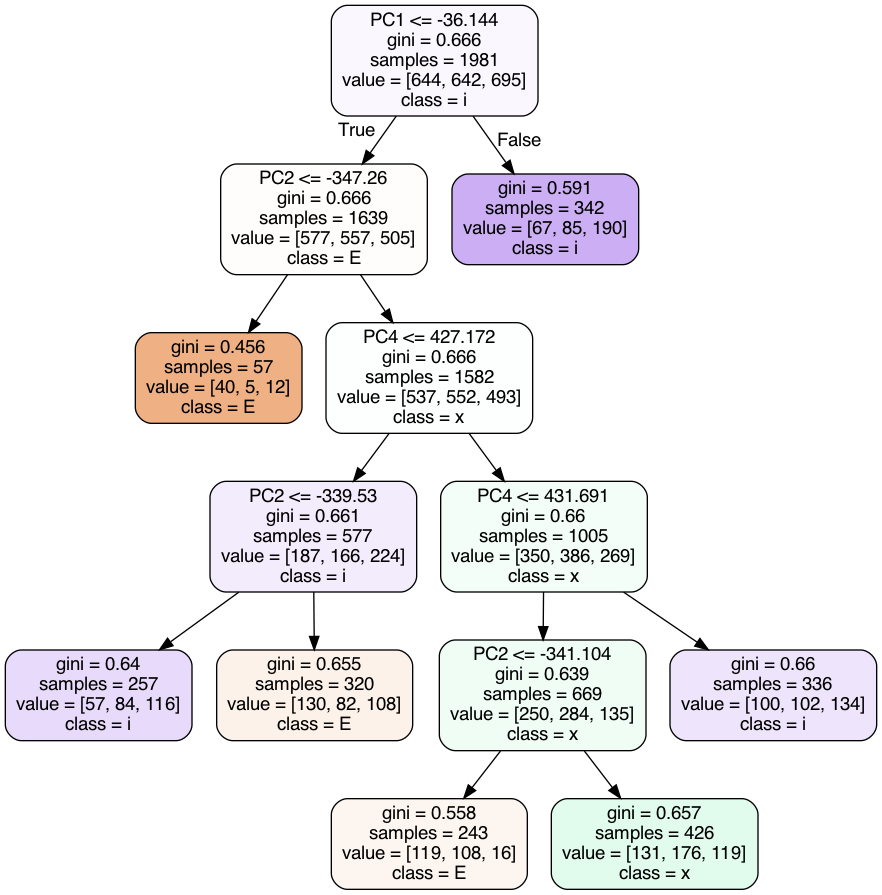

In [102]:
graph = pgv.AGraph("./tree_output.dot")
graph.draw('tree_output.png', prog='dot')
Image('tree_output.png')

## Accuracy

In [103]:
act = result_dict['y_15m']['act_15'].to_list()
pred = result_dict['y_15m']['pred_15'].to_list()

In [104]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
accuracy_metric = accuracy_score(act, pred)

In [105]:
np.array(pred).sum()

-928

In [106]:
accuracy_metric

0.3265668987998222

In [107]:
print(f1_score(act, pred, average="macro"))
print(precision_score(act, pred, average="macro"))
print(recall_score(act, pred, average="macro"))

0.3258313206303424
0.329197490227854
0.32703450584280774


In [108]:
confusion = confusion_matrix(act, pred)
confusion

array([[1521, 1327, 1336],
       [1801, 1259, 1380],
       [1950, 1296, 1628]])

In [109]:
from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(act, pred))


Classification Report

              precision    recall  f1-score   support

          -1       0.29      0.36      0.32      4184
           0       0.32      0.28      0.30      4440
           1       0.37      0.33      0.35      4874

    accuracy                           0.33     13498
   macro avg       0.33      0.33      0.33     13498
weighted avg       0.33      0.33      0.33     13498



## Trading Profit Evaluation

In [110]:
##필요한 DataSet
predict_res_dict= result_dict.copy()
temp_d = classify_predict_data_set.copy()
original_col = temp_d.columns.to_list()

##Label 생성
for i in range(1, 21):
    num_label = str(i) + 'm'
    
    #price change times 100!
    temp_d['price_' + num_label] = (temp_d['close'].shift(-i) - temp_d['close']) * 100
    
    #만원단위 Tick Value(Lead로 계산하기위해 shift(-i))
    temp_d['tick_value_' + num_label] = (temp_d['close'].shift(-i) - temp_d['close'])/0.05*2.5
    
    temp_d['ret_' + num_label] = ((temp_d['close'].shift(-i) - temp_d['close'])/temp_d['close']) * 100
    temp_d['logret_' + num_label] = (np.log(temp_d['close'].shift(-i)/temp_d['close'])) * 100

In [111]:
temp_d

,close,BBANDS_upperband,BBANDS_middleband,BBANDS_lowerband,DEMA,EMA,HT_TRENDLINE,KAMA,MA,MIDPOINT,MIDPRICE,SAR,SAREXT,SMA,T3,TEMA,TRIMA,WMA,ADX,ADXR,APO,BOP,CCI,CMO,DX,macd_MACD,macdsignal_MACD,macdhist_MACD,macd_MACDEXT,macdsignal_MACDEXT,macdhist_MACDEXT,macd_MACDFIX,macdsignal_MACDFIX,macdhist_MACDFIX,MFI,MINUS_DI,MINUS_DM,MOM,PLUS_DI,PLUS_DM,PPO,ROC,ROCP,ROCR,ROCR100,RSI,slowk,slowd,fastk_STOCHF,fastd_STOCHF,slowk_STOCHRSI,slowd_STOCHRSI,TRIX,ULTOSC,WILLR,AD,ADOSC,OBV,ATR,NATR,TRANGE,AVGPRICE,MEDPRICE,WCLPRICE,HT_DCPERIOD,HT_DCPHASE,HT_TRENDMODE,CDL2CROWS,CDL3BLACKCROWS,CDL3INSIDE,CDL3LINESTRIKE,CDL3OUTSIDE,CDL3STARSINSOUTH,CDL3WHITESOLDIERS,CDLABANDONEDBABY,CDLADVANCEBLOCK,CDLBELTHOLD,CDLBREAKAWAY,CDLCLOSINGMARUBOZU,CDLCONCEALBABYSWALL,CDLCOUNTERATTACK,CDLDARKCLOUDCOVER,CDLDOJI,CDLDOJISTAR,CDLDRAGONFLYDOJI,CDLENGULFING,CDLEVENINGDOJISTAR,CDLEVENINGSTAR,CDLGAPSIDESIDEWHITE,CDLGRAVESTONEDOJI,CDLHAMMER,CDLHANGINGMAN,CDLHARAMI,CDLHARAMICROSS,CDLHIKKAKE,CDLHIKKAKEMOD,CDLHOMINGPIGEON,CDLIDENTICAL3CROWS,CDLINNECK,CDLINVERTEDHAMMER,CDLKICKING,CDLKICKINGBYLENGTH,CDLLADDERBOTTOM,CDLLONGLEGGEDDOJI,CDLLONGLINE,CDLMARUBOZU,CDLMATCHINGLOW,CDLMATHOLD,CDLMORNINGDOJISTAR,CDLMORNINGSTAR,CDLONNECK,CDLPIERCING,CDLRICKSHAWMAN,CDLRISEFALL3METHODS,CDLSEPARATINGLINES,CDLSHOOTINGSTAR,CDLSHORTLINE,CDLSPINNINGTOP,CDLSTALLEDPATTERN,CDLSTICKSANDWICH,CDLTAKURI,CDLTASUKIGAP,CDLTHRUSTING,CDLTRISTAR,CDLUNIQUE3RIVER,CDLUPSIDEGAP2CROWS,CDLXSIDEGAP3METHODS,BETA,CORREL,LINEARREG,LINEARREG_ANGLE,LINEARREG_INTERCEPT,LINEARREG_SLOPE,STDDEV,TSF,VAR,ADD,DIV,MAX,MIN,MULT,SUB,SUM,price_1m,tick_value_1m,ret_1m,logret_1m,price_2m,tick_value_2m,ret_2m,logret_2m,price_3m,tick_value_3m,ret_3m,logret_3m,price_4m,tick_value_4m,ret_4m,logret_4m,price_5m,tick_value_5m,ret_5m,logret_5m,price_6m,tick_value_6m,ret_6m,logret_6m,price_7m,tick_value_7m,ret_7m,logret_7m,price_8m,tick_value_8m,ret_8m,logret_8m,price_9m,tick_value_9m,ret_9m,logret_9m,price_10m,tick_value_10m,ret_10m,logret_10m,price_11m,tick_value_11m,ret_11m,logret_11m,price_12m,tick_value_12m,ret_12m,logret_12m,price_13m,tick_value_13m,ret_13m,logret_13m,price_14m,tick_value_14m,ret_14m,logret_14m,price_15m,tick_value_15m,ret_15m,logret_15m,price_16m,tick_value_16m,ret_16m,logret_16m,price_17m,tick_value_17m,ret_17m,logret_17m,price_18m,tick_value_18m,ret_18m,logret_18m,price_19m,tick_value_19m,ret_19m,logret_19m,price_20m,tick_value_20m,ret_20m,logret_20m
49444,250.05,250.129666,249.98,249.830334,249.849102,250.047453,249.900408,250.014623,249.935000,249.950,249.975,307.95,-307.95,249.935000,250.006417,249.968051,249.870208,249.945054,19.341571,24.655781,0.130449,0.200000,7.679325,1.724504,8.394569,-0.024446,-0.056899,0.032452,0.130449,-0.001674,0.132123,-0.023481,-0.054693,0.031212,61.337197,16.849616,0.563908,-0.10,19.937757,0.667259,0.052197,-0.039976,-0.000400,0.999600,99.960024,50.862252,55.767196,34.462081,80.000000,55.767196,55.767196,34.462081,-0.008733,51.108857,-42.857143,73418.66925,75.314902,339378,0.239051,0.095601,0.25,250.0000,250.000000,250.0125,19.090371,206.300584,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.439575,0.812729,250.094286,0.862520,249.898571,0.015055,0.074833,250.109341,0.0056,499.95,1.001001,250.25,249.55,62487.4850,0.25,7498.05,-20.0,-10.0,-0.079984,-0.080016,-25.0,-12.5,-0.099980,-0.100030,-30.0,-15.0,-0.119976,-0.120048,-35.0,-17.5,-0.139972,-0.140070,-30.0,-15.0,-0.119976,-0.120048,-35.0,-17.5,-0.139972,-0.140070,-45.0,-22.5,-0.179964,-0.180126,-45.0,-22.5,-0.179964,-0.180126,-30.0,-15.0,-0.119976,-0.120048,-50.0,-25.0,-0.199960,-0.200160,-40.0,-20.0,-0.159968,-0.160096,-40.0,-20.0,-0.159968,-0.160096,-55.0,-27.5,-0.219956,-0.220198,-55.0,-27.5,-0.219956,-0.220198,-45.0,-22.5,-0.179964,-0.180126,305.0,152.5,1.219756,1.212377,295.0,147.5,1.179764,1.172859,310.0,155.0,1.239752,1.232130,325.0,162.5,1.299740,1.291366,285.0,142.5,1.139772,1.133326
49445,249.85,250.143303,249.96,249.776697,249.837243,250.0

In [112]:
trading_profit_RESULT = pd.DataFrame()
profit_df_result = pd.DataFrame()
profit_ratio = pd.DataFrame()


##검증 필요
y = [1, 3, 5, 10, 15, 20]

for i in y:
    profit_df = pd.merge(temp_d["tick_value_"+str(i)+"m"],result_dict["y_"+str(i)+"m"]["pred_"+str(i)],
                         left_index= True, right_index=True, how ="left")
    #앞: 5일치 train 데이터 빠짐 
    #뒤: lead 계산한 만큼 빠짐
#     profit_df = profit_df.dropna()
    
    
    for row in range(len(profit_df)):
        if profit_df["pred_"+str(i)].iloc[row] == 1:
            profit_df["pred_"+str(i)].iloc[row+1:row+i] = 0
        
        if profit_df["pred_"+str(i)].iloc[row] == -1:
            profit_df["pred_"+str(i)].iloc[row:row+i] = 0
            
#         elif profit_df["pred_"+str(i)].iloc[row] == -1:
#             profit_df["pred_"+str(i)].iloc[row+1:row+5] = 0

        else:
            pass
        
    
    profit_df["profit"+str(i)] = profit_df["tick_value_"+str(i)+"m"] * profit_df["pred_"+str(i)]
    profit_ratio["profit_ratio"+str(i)] = profit_df["profit"+str(i)]
    trading_profit_RESULT[str(i)+"m_cum_profit"] = profit_df["profit"+str(i)].cumsum()
    profit_df_result[str(i)+"m_predict"] = profit_df["pred_"+str(i)]
    
    
trading_profit_RESULT.dropna(how = "all")
    

,1m_cum_profit,3m_cum_profit,5m_cum_profit,10m_cum_profit,15m_cum_profit,20m_cum_profit
51424,0,-10,-15,-17.5,-12.5,-152.5
51425,0,-10,-15,-17.5,-12.5,-152.5
51426,-2.5,-10,-15,-17.5,-12.5,-152.5
51427,-5,-22.5,-15,-17.5,-12.5,-152.5
51428,-7.5,-22.5,-15,-17.5,-12.5,-152.5
...,...,...,...,...,...,...
64900,NaN,NaN,NaN,NaN,1027.5,1387.5
64901,NaN,NaN,NaN,NaN,1027.5,1387.5
64902,NaN,NaN,NaN,NaN,1027.5,1387.5
64903,NaN,NaN,NaN,NaN,NaN,1387.5


In [113]:
profit_ratio[profit_ratio>0].sum()

profit_ratio1     13777.5
profit_ratio3     10232.5
profit_ratio5      8747.5
profit_ratio10     6570.0
profit_ratio15     5390.0
profit_ratio20     4477.5
dtype: float64

In [114]:
profit_ratio[profit_ratio<0].sum()

profit_ratio1    -13452.5
profit_ratio3     -9225.0
profit_ratio5     -7325.0
profit_ratio10    -5950.0
profit_ratio15    -4362.5
profit_ratio20    -3090.0
dtype: float64

In [115]:
profit_ratio.sum().mean()

965.0000000000013

In [116]:
profit_ratio[profit_ratio>0].sum()/profit_ratio[profit_ratio<0].sum()

profit_ratio1    -1.024159
profit_ratio3    -1.109214
profit_ratio5    -1.194198
profit_ratio10   -1.104202
profit_ratio15   -1.235530
profit_ratio20   -1.449029
dtype: float64

In [117]:
profit_df_result

,1m_predict,3m_predict,5m_predict,10m_predict,15m_predict,20m_predict
49444,NaN,NaN,NaN,NaN,NaN,NaN
49445,NaN,NaN,NaN,NaN,NaN,NaN
49446,NaN,NaN,NaN,NaN,NaN,NaN
49447,NaN,NaN,NaN,NaN,NaN,NaN
49448,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
65279,NaN,NaN,NaN,NaN,NaN,NaN
65280,NaN,NaN,NaN,NaN,NaN,NaN
65281,NaN,NaN,NaN,NaN,NaN,NaN
65282,NaN,NaN,NaN,NaN,NaN,NaN


In [118]:
(profit_df_result<0).sum()

1m_predict     0
3m_predict     0
5m_predict     0
10m_predict    0
15m_predict    0
20m_predict    0
dtype: int64

In [119]:
(profit_df_result>0).sum()

1m_predict     4357
3m_predict     1669
5m_predict     1059
10m_predict     522
15m_predict     320
20m_predict     214
dtype: int64

In [120]:
(profit_df_result.dropna()>0).sum()

1m_predict     4357
3m_predict     1669
5m_predict     1059
10m_predict     522
15m_predict     320
20m_predict     214
dtype: int64

In [121]:
(profit_df_result.dropna()<0).sum()

1m_predict     0
3m_predict     0
5m_predict     0
10m_predict    0
15m_predict    0
20m_predict    0
dtype: int64

In [122]:
profit_df

,tick_value_20m,pred_20,profit20
49444,142.5,NaN,NaN
49445,145.0,NaN,NaN
49446,140.0,NaN,NaN
49447,130.0,NaN,NaN
49448,140.0,NaN,NaN
...,...,...,...
65279,NaN,NaN,NaN
65280,NaN,NaN,NaN
65281,NaN,NaN,NaN
65282,NaN,NaN,NaN


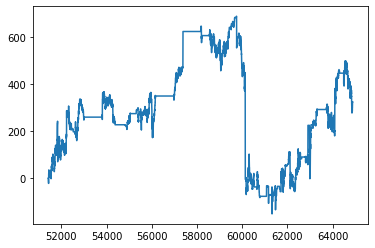

In [123]:
trading_profit_RESULT["1m_cum_profit"].plot()

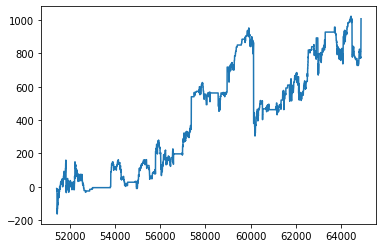

In [124]:
trading_profit_RESULT["3m_cum_profit"].plot()

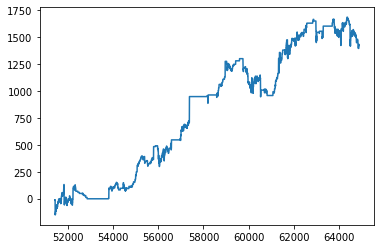

In [125]:
trading_profit_RESULT["5m_cum_profit"].plot()

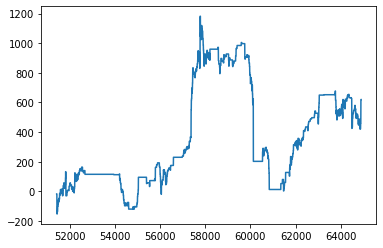

In [126]:
trading_profit_RESULT["10m_cum_profit"].plot()

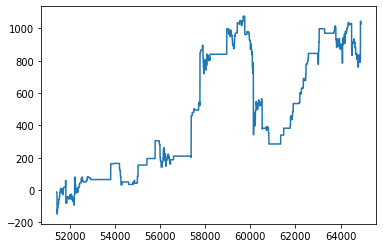

In [127]:
trading_profit_RESULT["15m_cum_profit"].plot()

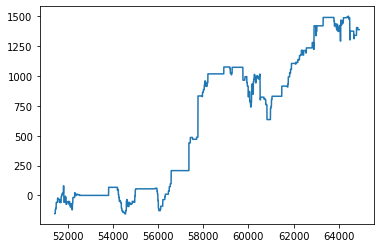

In [128]:
trading_profit_RESULT["20m_cum_profit"].plot()

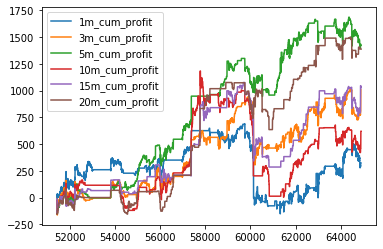

In [129]:
trading_profit_RESULT.plot()

In [130]:
raw_data_modify = raw_data.copy()

In [131]:
raw_data_modify = pd.to_datetime(raw_data_modify["일자"])

In [132]:
raw_data_modify

0       2019-10-30
1       2019-10-30
2       2019-10-30
3       2019-10-30
4       2019-10-30
           ...    
65279   2020-06-30
65280   2020-06-30
65281   2020-06-30
65282   2020-06-30
65283   2020-06-30
Name: 일자, Length: 65284, dtype: datetime64[ns]

In [133]:
trading_profit_RESULT_with_date = pd.merge(trading_profit_RESULT, raw_data_modify, how="left", left_index=True, right_index=True)

In [134]:
trading_profit_RESULT_with_date.index = trading_profit_RESULT_with_date["일자"]

In [135]:
trading_profit_RESULT_with_date.pop("일자")

일자
2020-05-04   2020-05-04
2020-05-04   2020-05-04
2020-05-04   2020-05-04
2020-05-04   2020-05-04
2020-05-04   2020-05-04
                ...    
2020-06-30   2020-06-30
2020-06-30   2020-06-30
2020-06-30   2020-06-30
2020-06-30   2020-06-30
2020-06-30   2020-06-30
Name: 일자, Length: 15873, dtype: datetime64[ns]

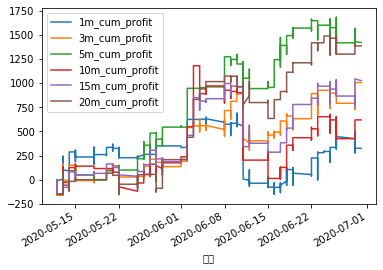

In [166]:
trading_profit_RESULT_with_date.plot()